# Build a Conditional GAN

### Goals
Conditional GAN is used in order to generate hand-written images of digits, conditioned on the digit to be generated (the class vector). This will let us choose which digit we want to generate.

  

### Learnings
1.   Learnt the technical difference between a conditional and unconditional GAN.
2.   Understood the distinction between the class and noise vector in a conditional GAN.


Paper : https://arxiv.org/abs/1411.1784


Used discriminator and generator from DCGAN project

Project link : (https://github.com/umang4002/Deep-ConvolutionGAN/blob/master/DCgan.ipynb)

1. **Project Introduction:**
   - In this project, I worked with the MNIST dataset.
   - The main goal was to create a generator and discriminator for generating images, but this concept could have been extended to other types of data like animals or faces.

2. **No Architecture Changes:**
   - I did not modify the architectures of the generator or discriminator.
   - Both models remained the same; only the input data changed.

3. **Generator Modification:**
   - The generator accepted a new argument called `input_dim`.
   - This change combined both the noise and class vectors.
   - This allowed me to generate data based on specific attributes.

4. **Variable Naming Clarity:**
   - I used clear and descriptive variable names in my code.
   - This enhanced code readability and maintainability.

5. **Code Reusability:**
   - By making this modification, I enabled the reuse of the generator and discriminator code with different parameters.

6. **Importing Libraries:**
   - I started by importing the necessary libraries for my project.

7. **Building Models:**
   - I constructed the generator and discriminator models.

These points provide a detailed account of how I completed the project, emphasizing the actions taken and decisions made during the project in the past context.



#### Packages and Visualization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is the default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: Number of channels the input feature representation has
            output_channels: Number of channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### Discriminator

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: Number of channels the input feature representation has
            output_channels: Number of channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

**Creating One-Hot Vectors for Labels:**

1. **Task Description:**
   - In the context of conditional GANs, I needed to modify the input vector for the generator to include class information.
   - To achieve this, I had to create one-hot vectors for each label.

2. **One-Hot Encoding:**
   - I implemented one-hot encoding for labels, ensuring that each label was transformed into a vector.
   - The length of each one-hot vector matched the total number of classes.
   - Specifically, for each one-hot vector, all elements were set to 0 except for the index corresponding to the class, which was set to 1.

3. **Batch Processing:**
   - To efficiently handle multiple images' labels (for example, in a batch), I applied this one-hot encoding process across the entire batch.
   - This ensured that the class information was accurately represented for each image in the batch.

4. **PyTorch Functional Library:**
   - I leveraged a class available within the PyTorch functional library to simplify and optimize the creation of one-hot vectors.
   - This library function streamlined the process and reduced the need for manual coding.

By following these steps, I successfully integrated one-hot vectors representing class information into the generator's input, enabling conditional generation of data based on specific classes.

In [4]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''

    return F.one_hot(labels, num_classes = n_classes)


**Creating a Function to Concatenate Two Vectors:**

1. **Task Description:**
   - In order to enhance the conditional GAN, I needed to develop a function that could concatenate two vectors.
   - This function would play a crucial role in combining the one-hot class vector and the noise vector before passing them to the generator.
   - Additionally, the same function would be used when adding the class channels to the discriminator.

2. **Vector Compatibility:**
   - It was important to ensure that both vectors being concatenated were of the same data type, specifically floats.

3. **Concatenation Process:**
   - I designed the function to efficiently concatenate two vectors, allowing for flexibility in combining various types of data.
   - This involved taking the input vectors, which could represent the one-hot class information and noise, and merging them into a single vector.

4. **Generator Input:**
   - The concatenated vector was utilized as the input to the generator, enabling the generator to generate data conditioned on both class and noise information.

5. **Discriminator Modification:**
   - Additionally, the same function was employed to add class channels to the discriminator, enhancing its ability to differentiate between different classes of generated data.



In [5]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        noise vector of shape (n_samples, z_dim) (no need to know the second dimension's size.)
      y: (n_samples, ?) the second vector.
        one-hot class vector with the shape (n_samples, n_classes), (no need to know the second dimension's size.)
    '''
    # For ensuring that the function should return float.
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

## Training

Important Parameters:

*   mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
*   n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [6]:
mnist_shape = (1, 28, 28)
n_classes = 10

Some more important parameters

  *   criterion: the loss function
  *   n_epochs: the number of iterations through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type


In [19]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 30
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download= True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

**Initializing Generator, Discriminator, and Optimizers:**

1. **Generator Initialization:**
   - To begin this phase of the project, I initialized the generator, discriminator, and optimizers. This required updates to the input dimensions for both models.
   - Specifically, I calculated the size of the input vector for the generator. In conditional GANs, the generator's input consists of the noise vector concatenated with the class vector.
   
2. **Generator Input Size Calculation:**
   - To calculate the input size for the generator, I considered the dimensions of both the noise vector and the one-hot encoded class vector.
   
3. **Discriminator Modification:**
   - For the discriminator, modifications were made to accommodate multiple classes. I added a channel for every class to ensure it could effectively distinguish between different classes of generated data.
   
4. **Optimizers Initialization:**
   - I also initialized optimizers for both the generator and discriminator. This involved selecting appropriate optimization algorithms and setting their respective parameters.

This phase was essential for ensuring that the generator and discriminator were correctly initialized and configured to work with conditional GANs, where the input dimensions play a crucial role in generating and evaluating data conditioned on class information.

In [20]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

In [21]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

To optimize the conditional GAN training, I introduced class information into both the generator and discriminator. This ensured that both models were aware of the specific class they were dealing with.

For instance, when generating a "1," the generator was informed about the class requirement, while the discriminator was also alerted to expect a "1." This alignment helped the discriminator accurately distinguish between generated images and the target class, enhancing overall GAN performance.

  0%|          | 0/469 [00:00<?, ?it/s]

Working


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 4.491326811790466, discriminator loss: 0.049726715378463265


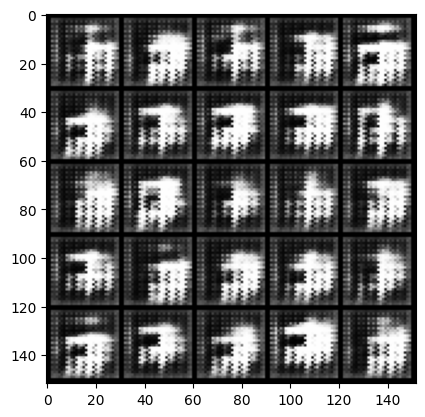

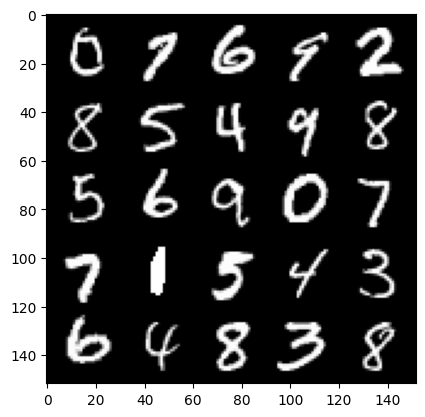

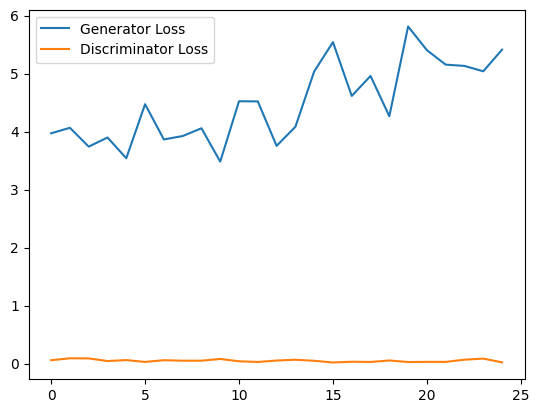

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 4.383930289268494, discriminator loss: 0.06628512468840927


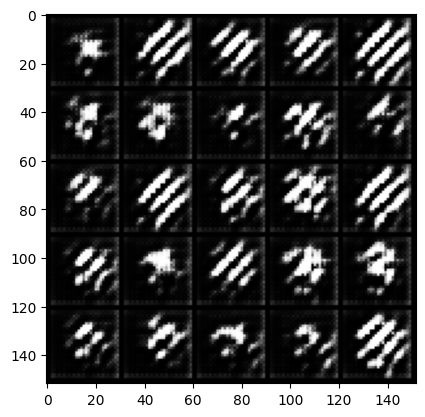

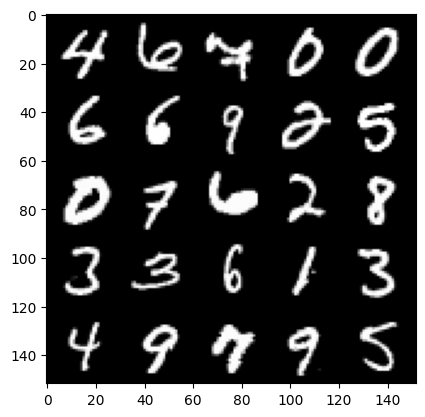

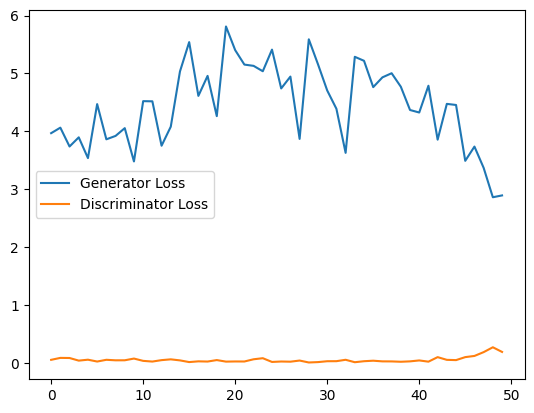

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 2.8365111937522887, discriminator loss: 0.19903458604216576


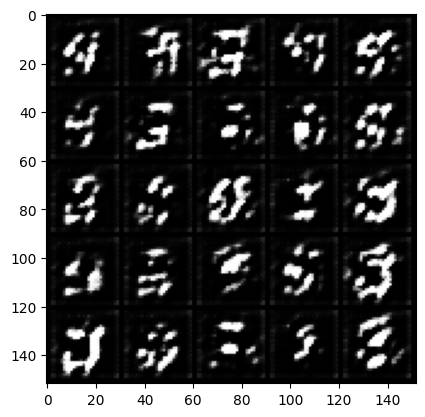

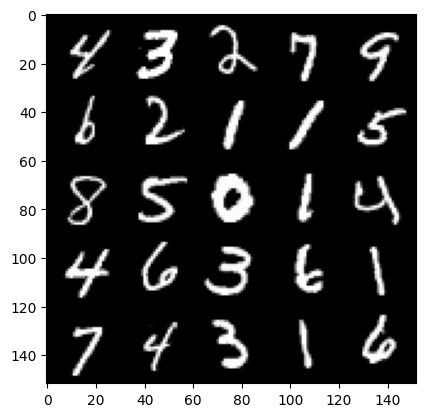

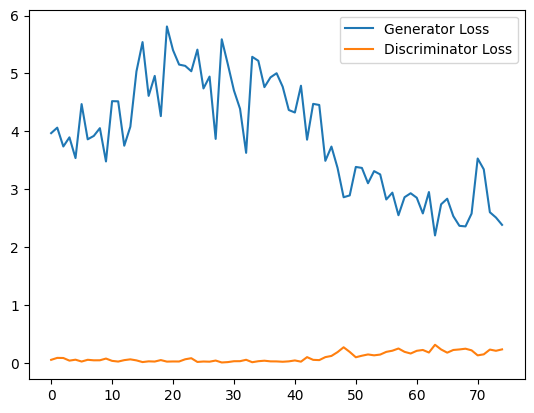

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 2.3715573136806487, discriminator loss: 0.2853155628591776


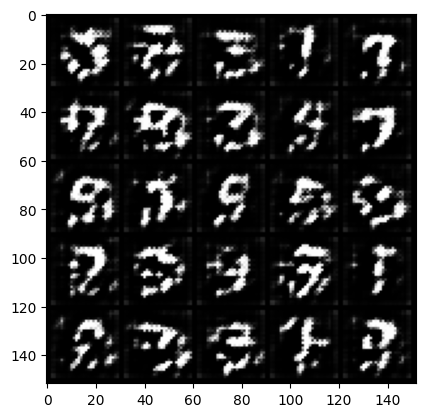

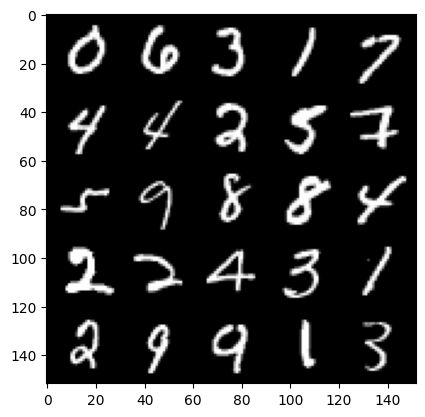

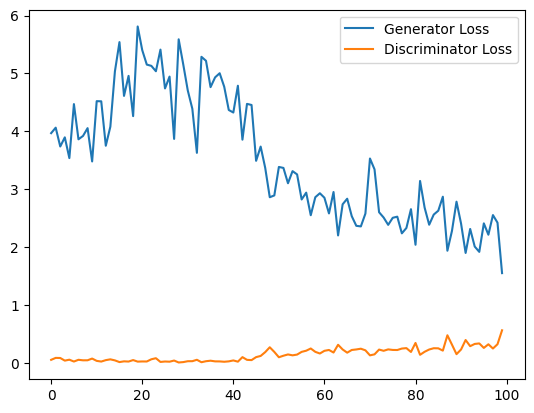

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.2777994923591613, discriminator loss: 0.3210040616840124


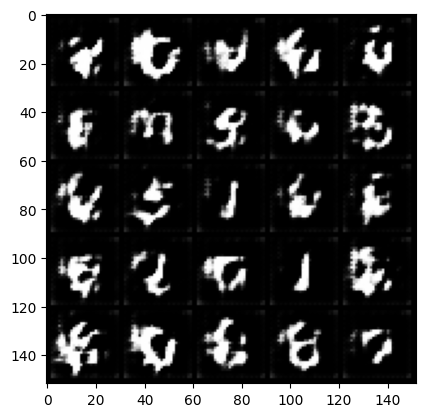

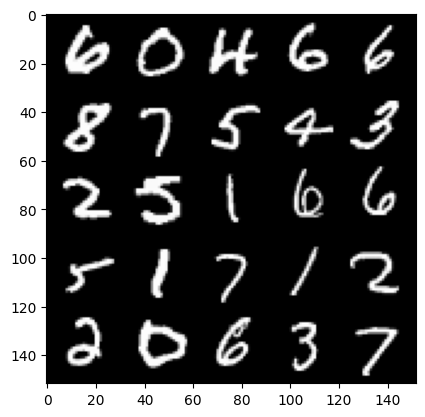

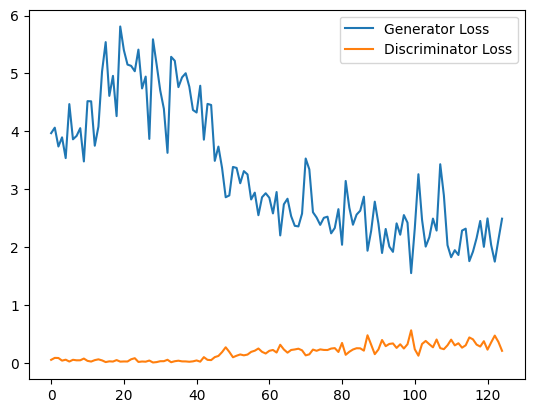

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.028036322593689, discriminator loss: 0.34764787113666534


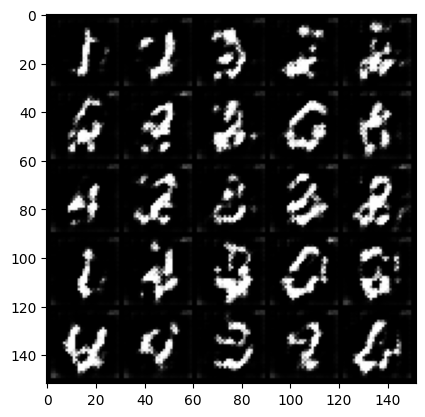

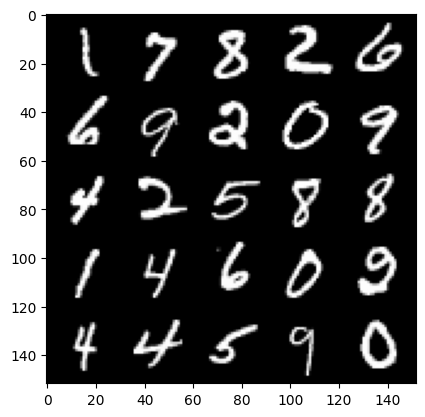

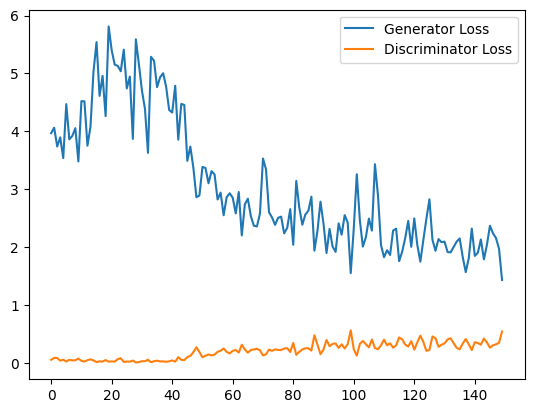

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.1554912219047546, discriminator loss: 0.3356208766400814


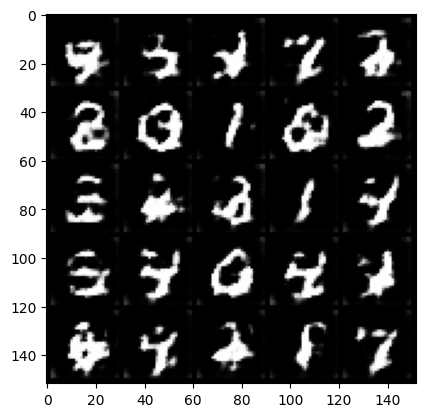

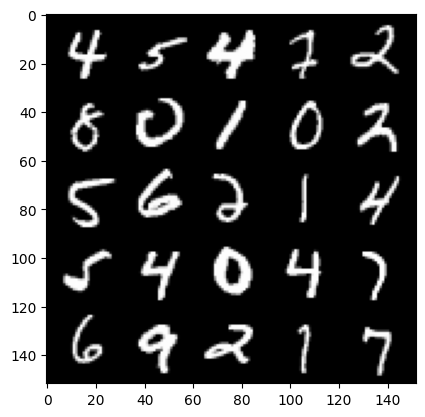

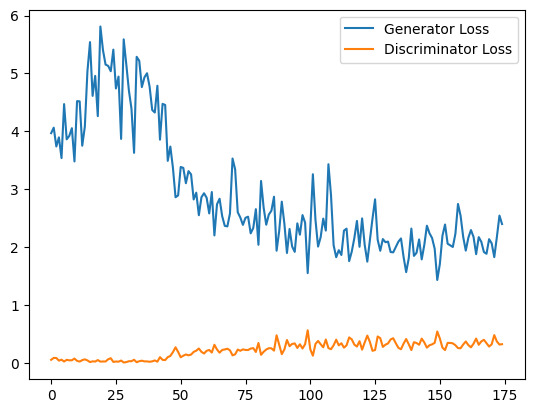

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 1.8900043013095855, discriminator loss: 0.3742790014147758


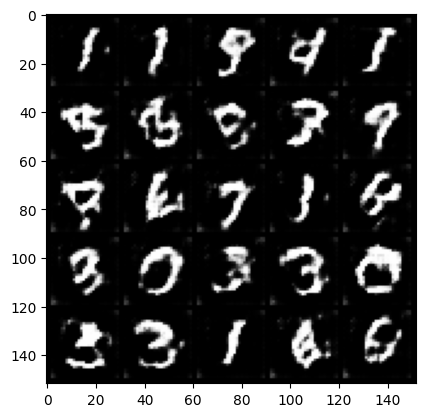

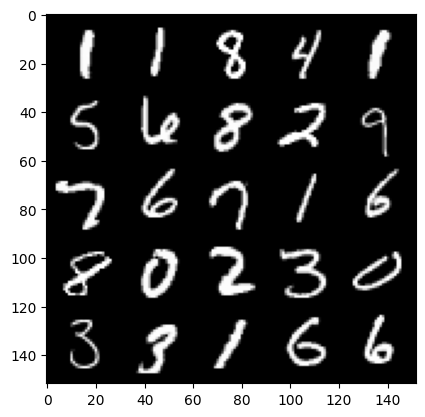

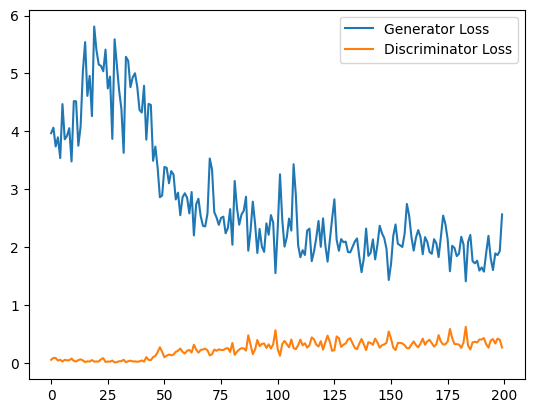

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 1.6976914798021316, discriminator loss: 0.39335689997673035


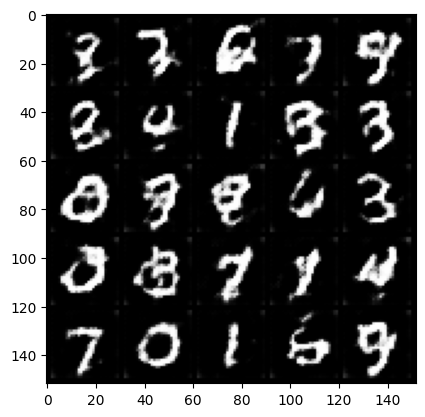

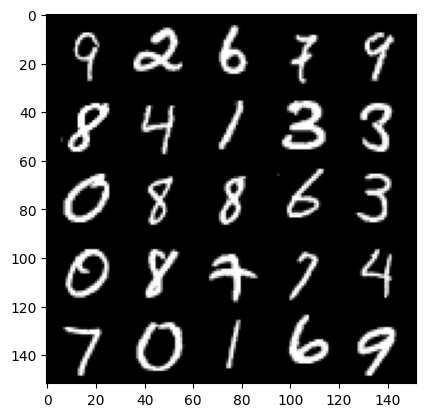

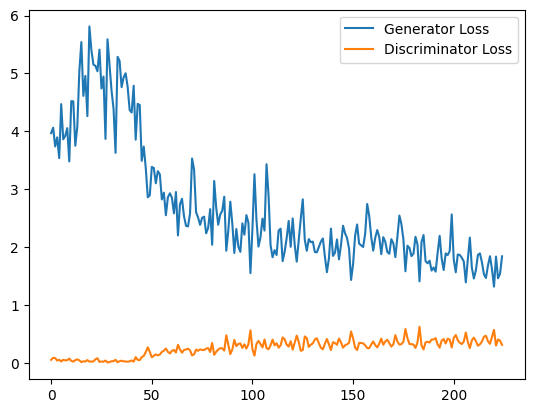

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 1.6410563476085662, discriminator loss: 0.406599322617054


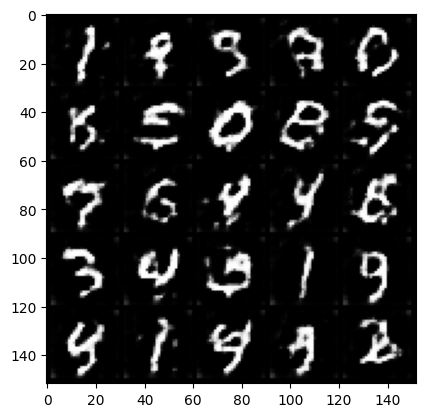

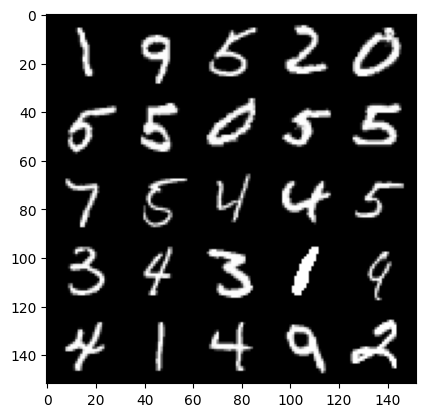

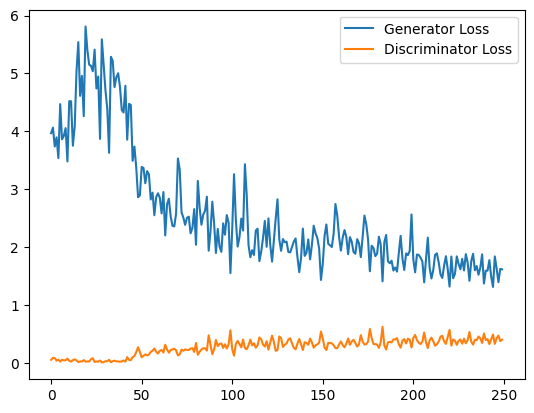

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 1.6189597445726394, discriminator loss: 0.4469300372302532


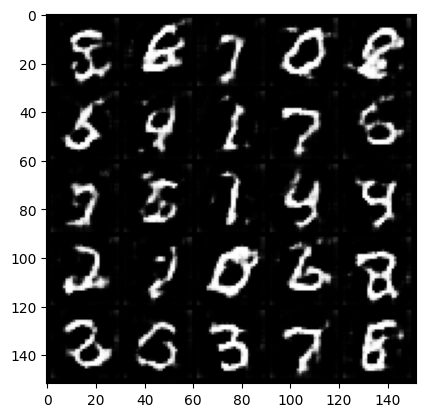

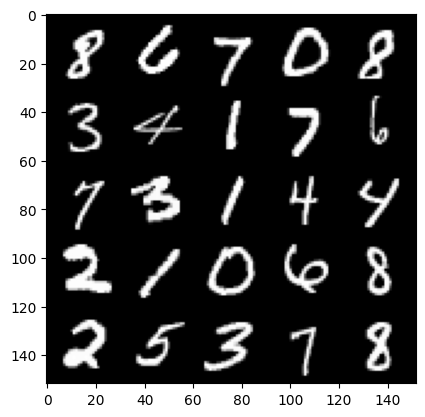

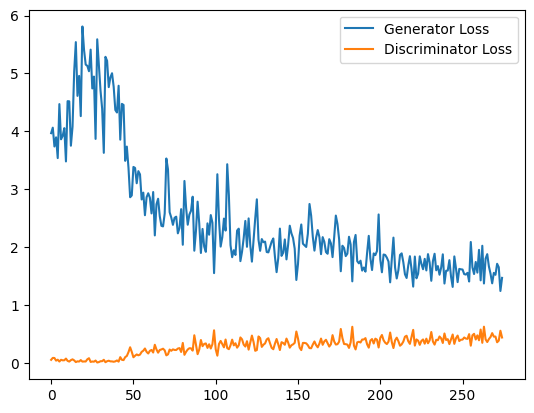

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.4467759248018264, discriminator loss: 0.4504889637231827


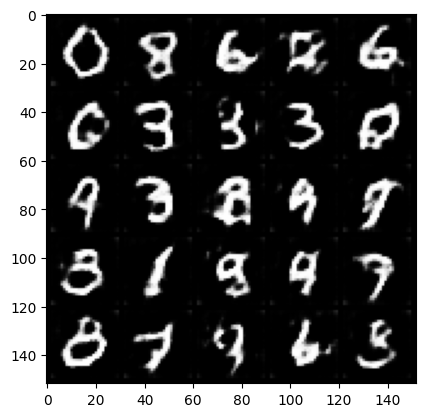

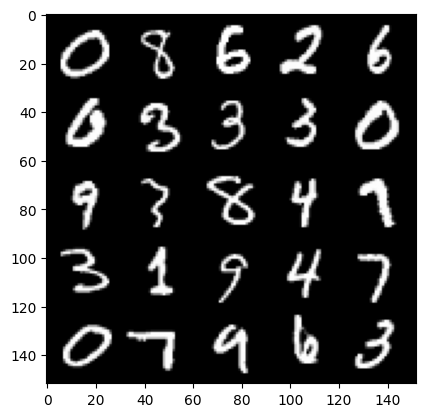

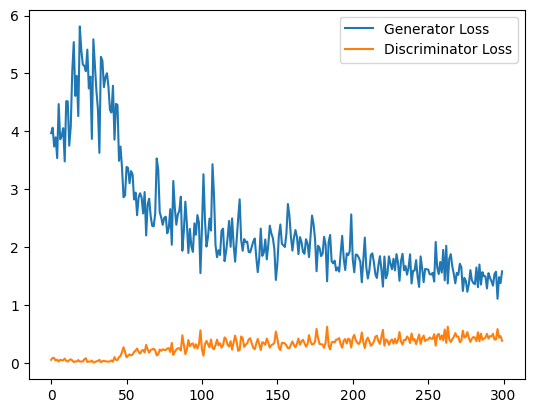

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.3481133238077163, discriminator loss: 0.46845137614011767


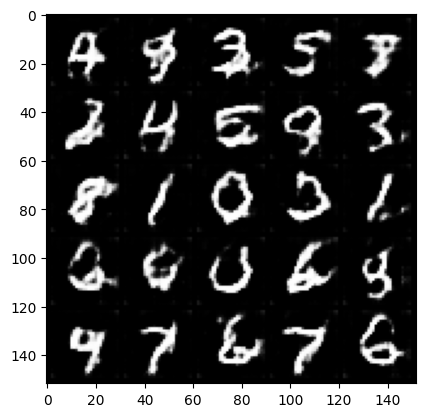

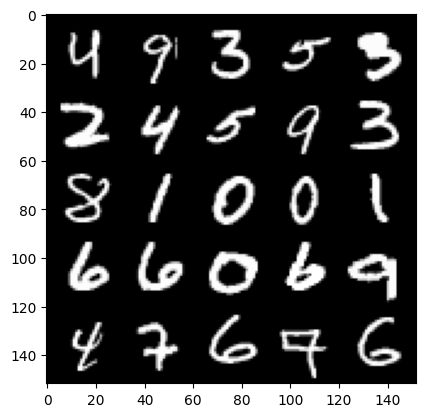

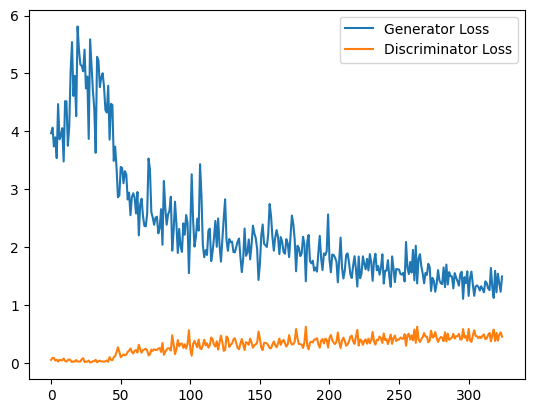

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.4987435508966447, discriminator loss: 0.4814314457178116


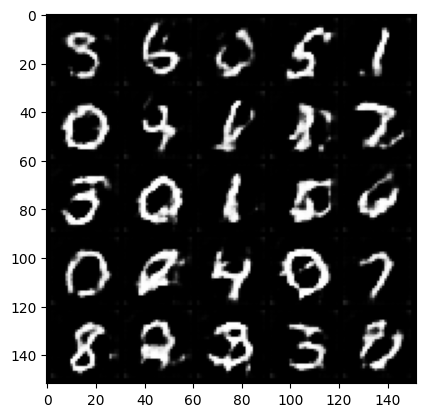

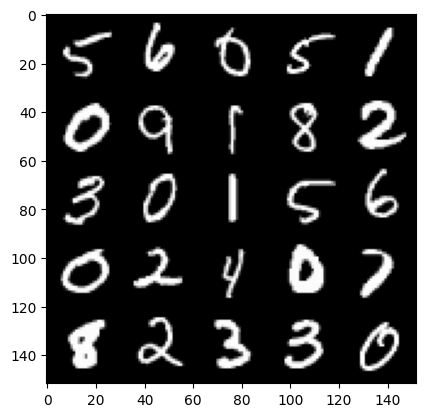

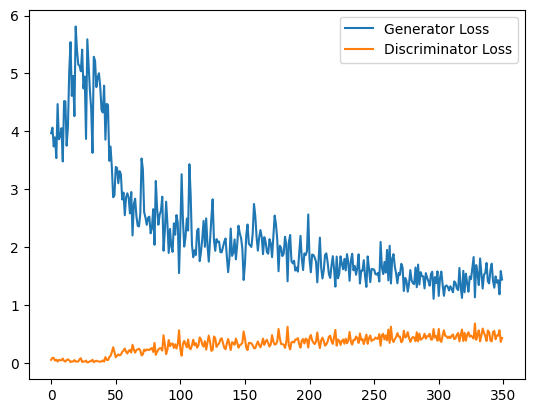

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.3316756751537322, discriminator loss: 0.5059808888435364


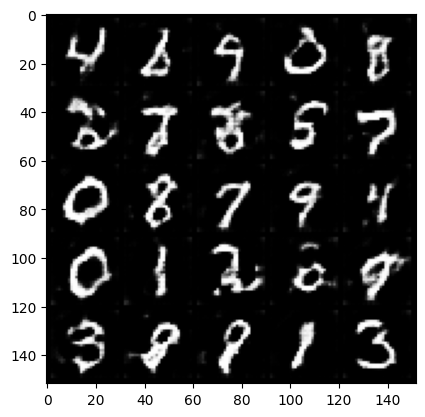

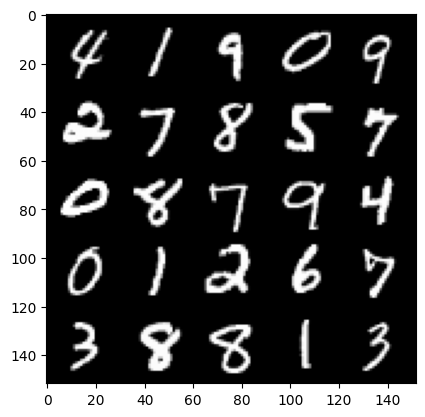

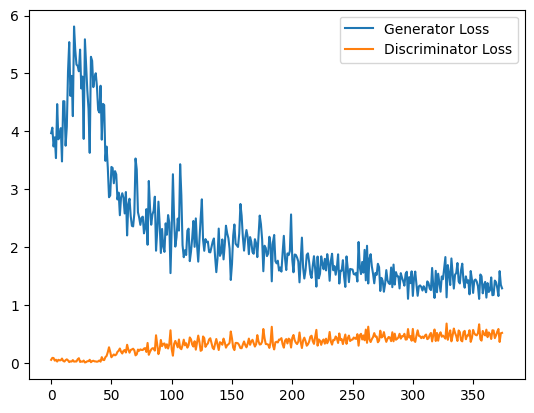

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.2734028502702712, discriminator loss: 0.5086591400504112


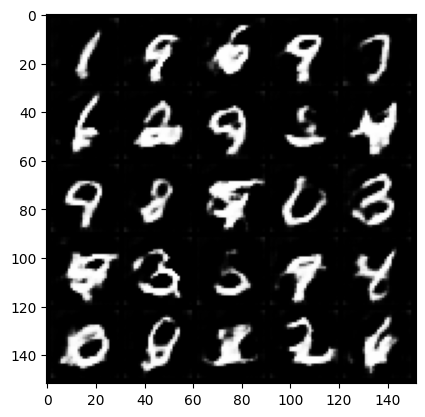

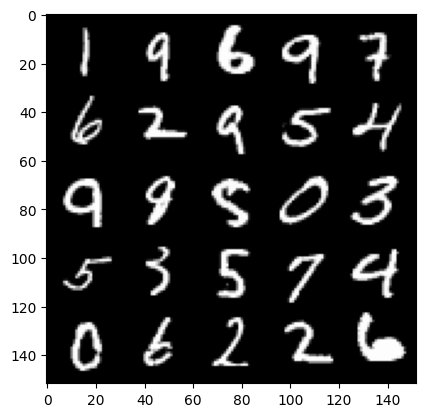

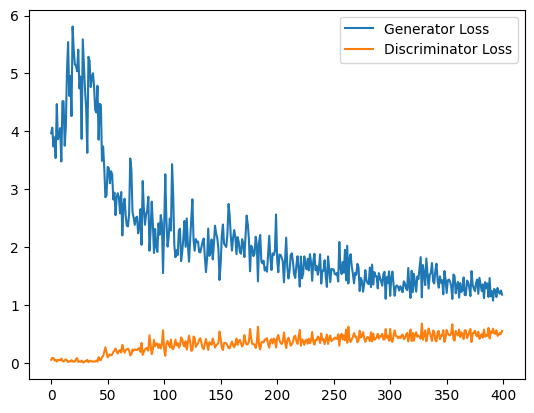

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.2704641313552856, discriminator loss: 0.5204587790966034


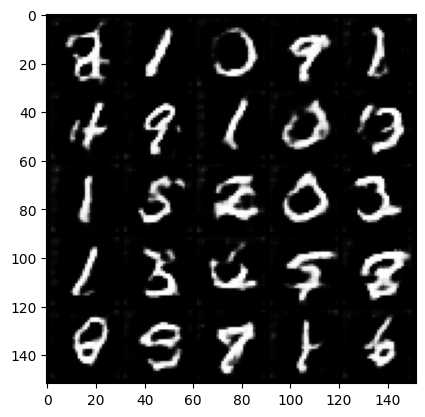

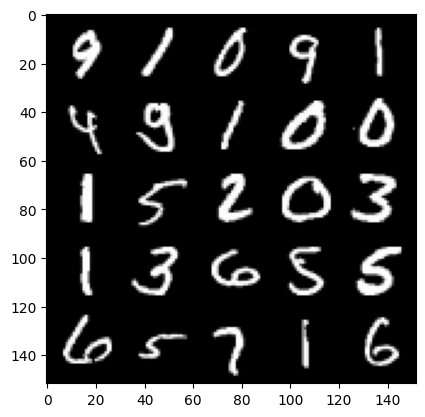

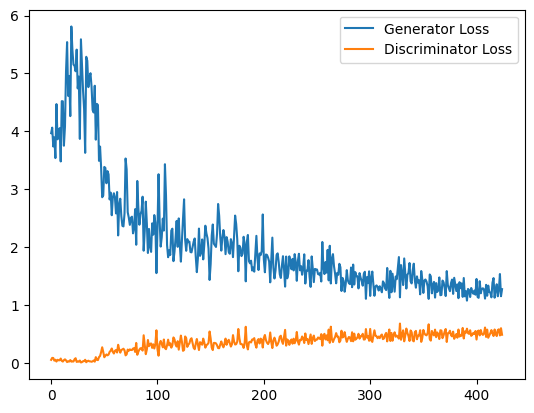

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 1.2515844880342484, discriminator loss: 0.5322844589948654


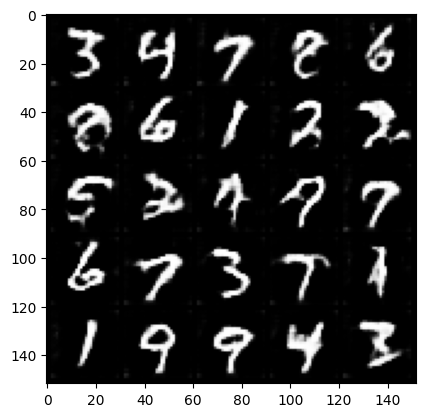

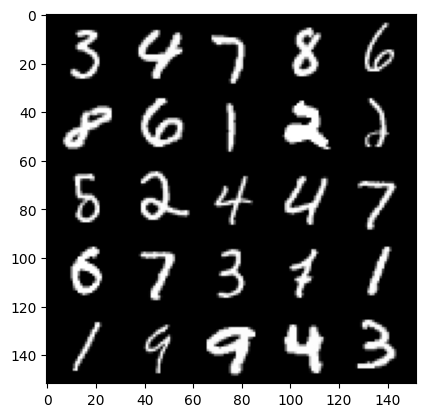

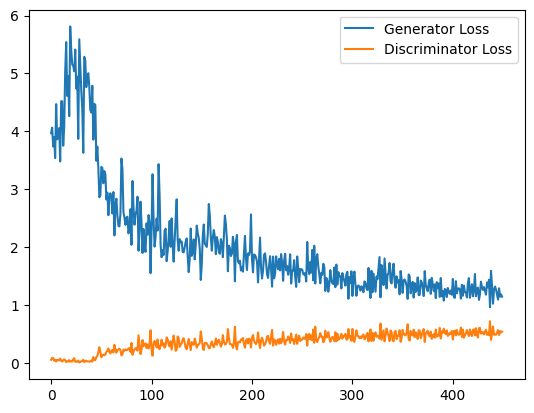

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 1.1934006589651107, discriminator loss: 0.5290217460393906


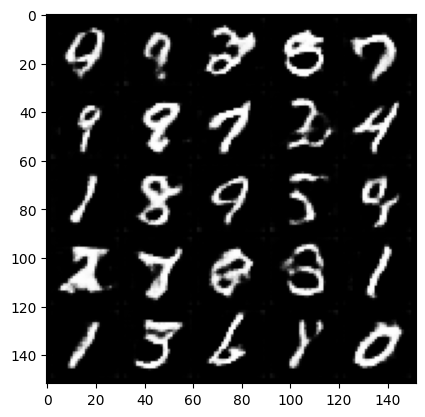

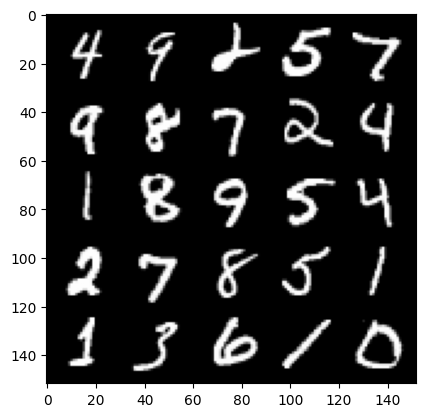

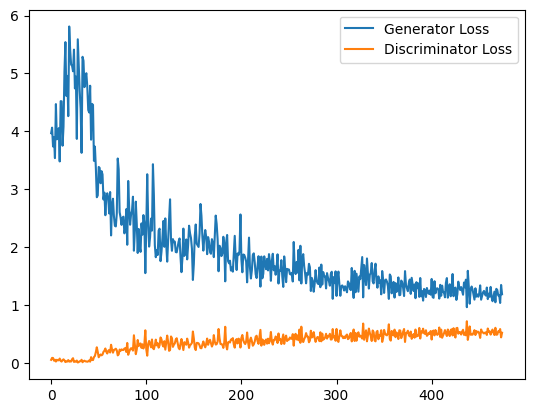

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 1.2031920874118804, discriminator loss: 0.5396865598559379


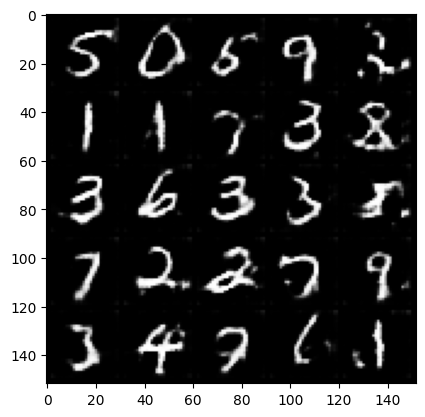

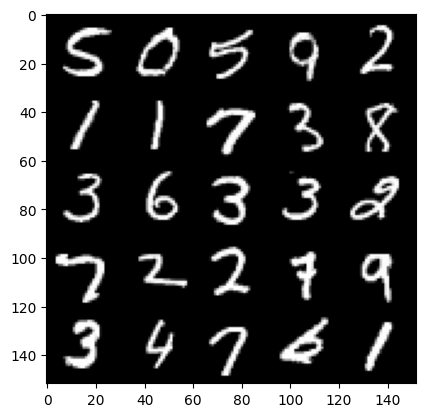

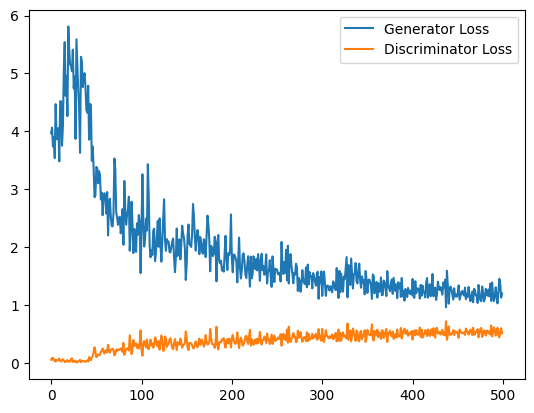

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 1.1434145653247834, discriminator loss: 0.5483683468699455


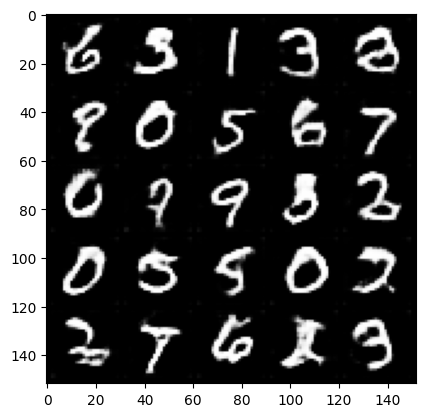

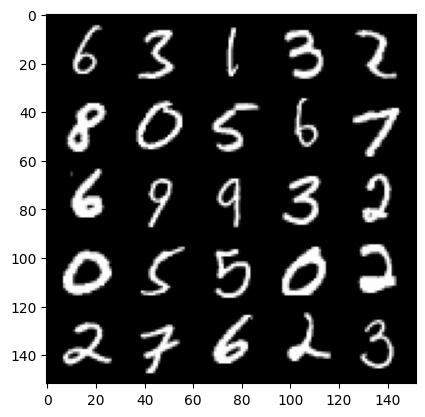

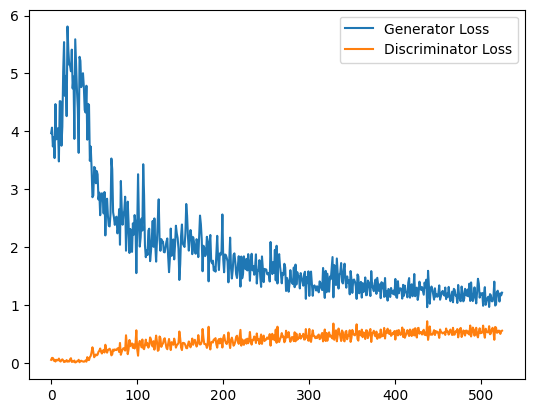

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 1.1387273674011231, discriminator loss: 0.5562477399110795


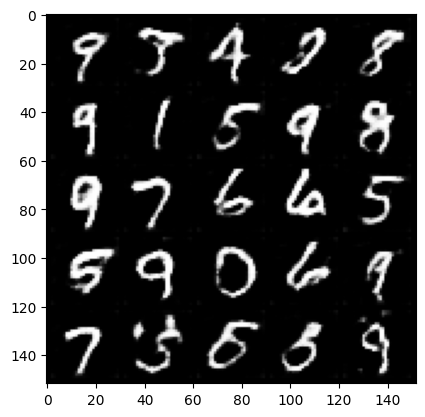

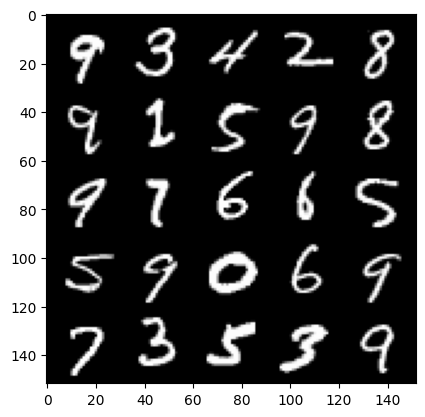

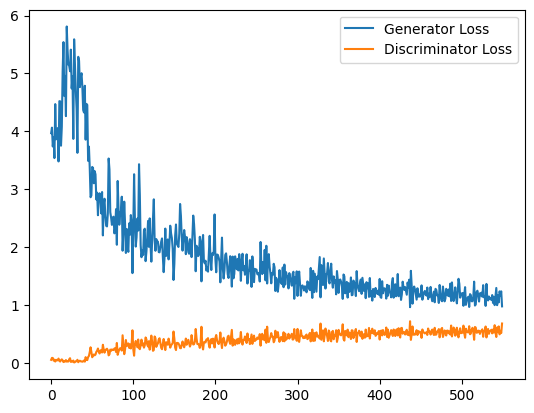

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 1.1485456405878067, discriminator loss: 0.5580140773653984


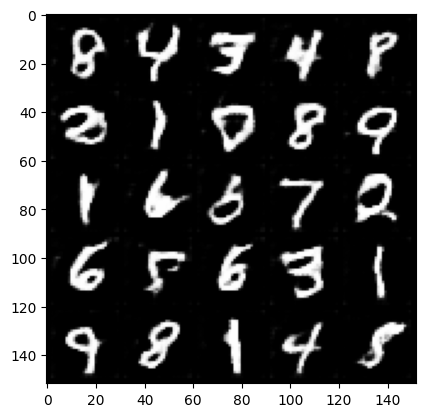

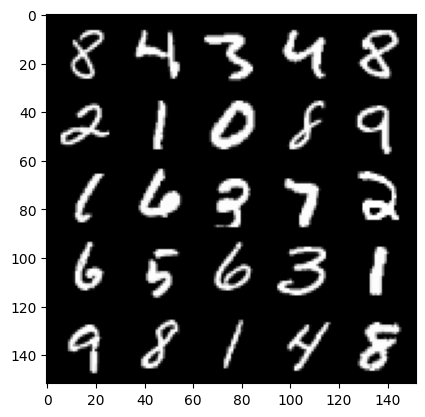

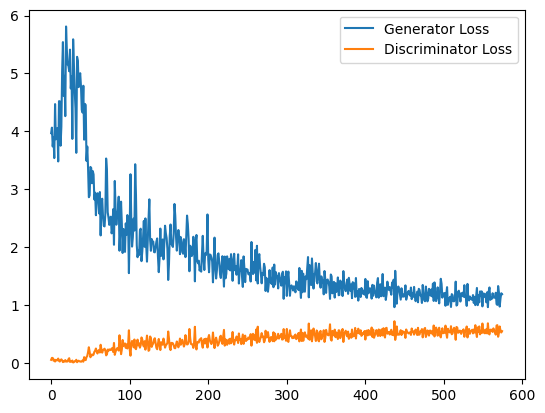

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 1.1083797549009322, discriminator loss: 0.565977266728878


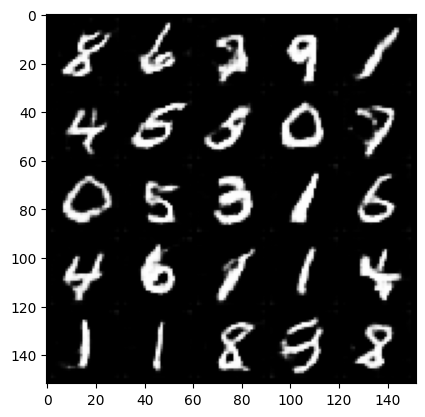

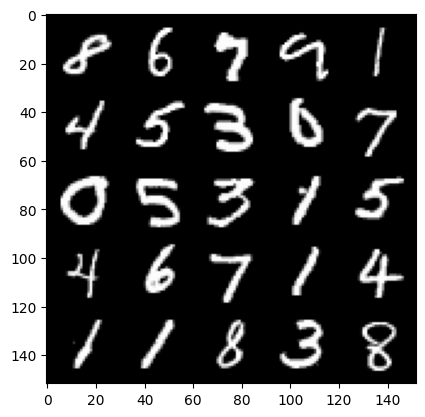

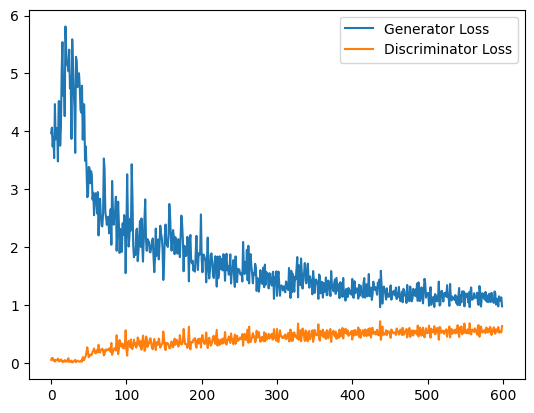

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 1.128316634297371, discriminator loss: 0.5696539589762688


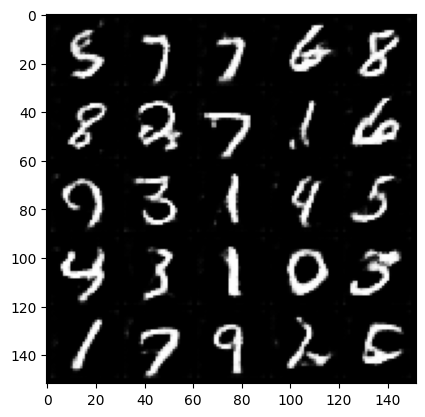

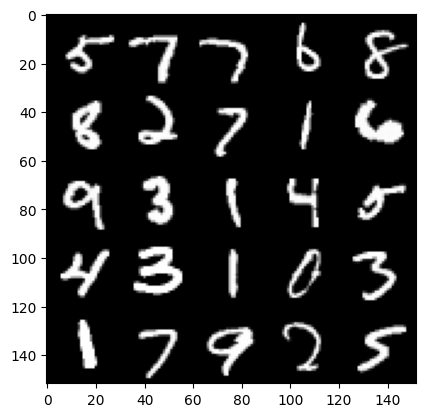

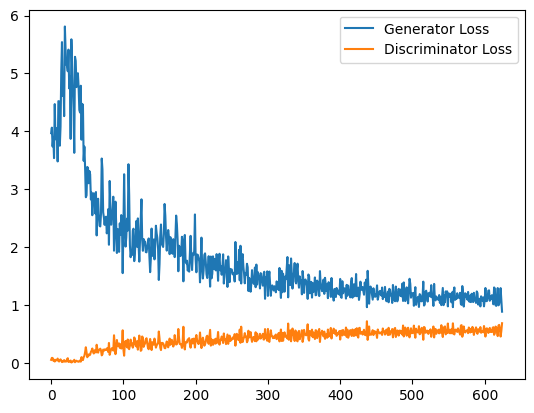

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 1.0836015309095384, discriminator loss: 0.5683813036680222


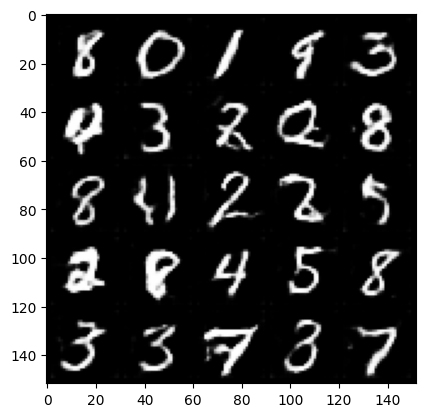

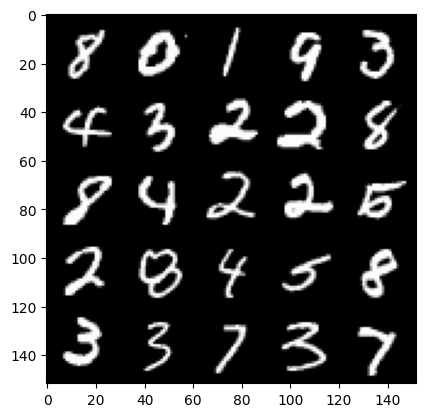

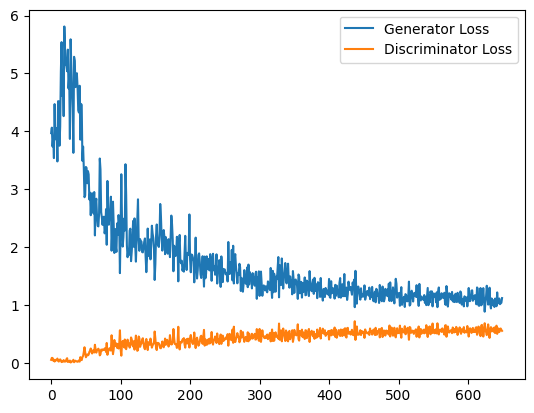

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 1.0700797721147537, discriminator loss: 0.5777556456327438


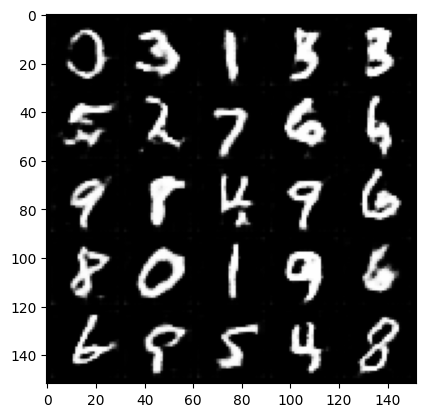

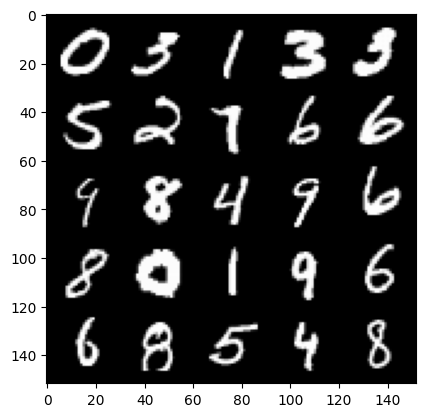

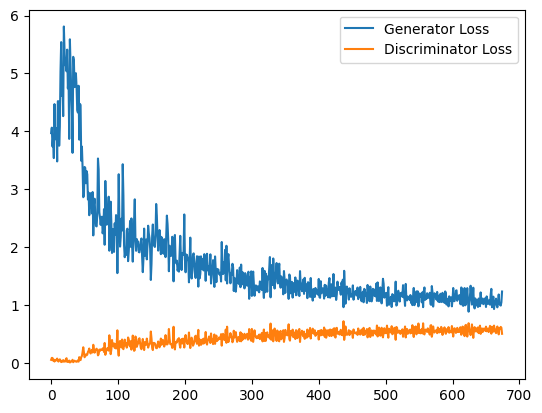

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 1.0633678206205368, discriminator loss: 0.5790908300280571


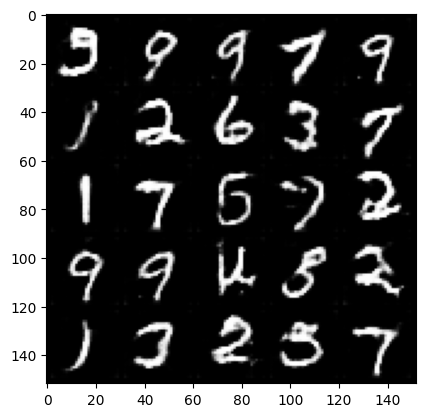

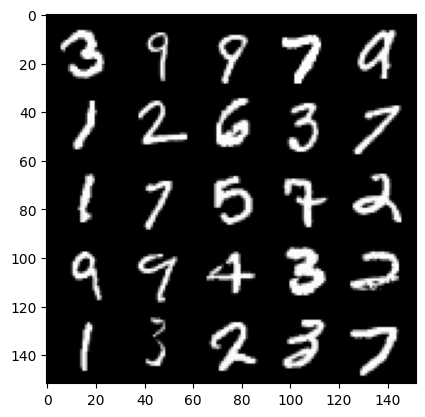

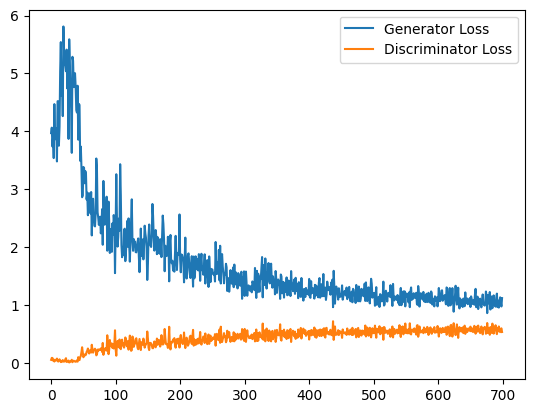

In [23]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):

    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)

        # For flattening the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Geting noise corresponding to the current batch_size
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        # Images from the generator
        # Steps: 1) Combined the noise vectors and the one-hot labels for the generator
        #        2) Generated the conditioned fake images


        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)


        #Sanity Check

        # Making sure that enough images were generated
        assert len(fake) == len(real)

        # Checking that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])

        # Ensuring it comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Descriminator predictions
        # Steps: 1) Created the input for the discriminator
        #           a) Combined the fake images with image_one_hot_labels,
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Got the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Got the discriminator's prediction on the reals as disc_real_pred


        fake_image_and_labels =  combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)


        # Sanity checks for shapes
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Enough predictions
        assert len(disc_real_pred) == len(real)
        # Different inputs
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)


        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keeping track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Updating generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keeping track of the generator losses
        generator_losses += [gen_loss.item()]


        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Working")
        cur_step += 1

Generation Of New Numbers

In [24]:
#Puting the generator
# in eval mode, both in general and so that batch norm
# doesn't cause issues and is using its eval statistics
gen = gen.eval()

#### Changing the Class Vector

Using the new model, I created various numbers and added interpolation for an exciting twist. I started from one image and produced in-between images that gradually transformed into the final image. Essentially, it's like smoothly changing one picture into another. I had the flexibility to pick the beginning and ending images thanks to the conditional GAN.

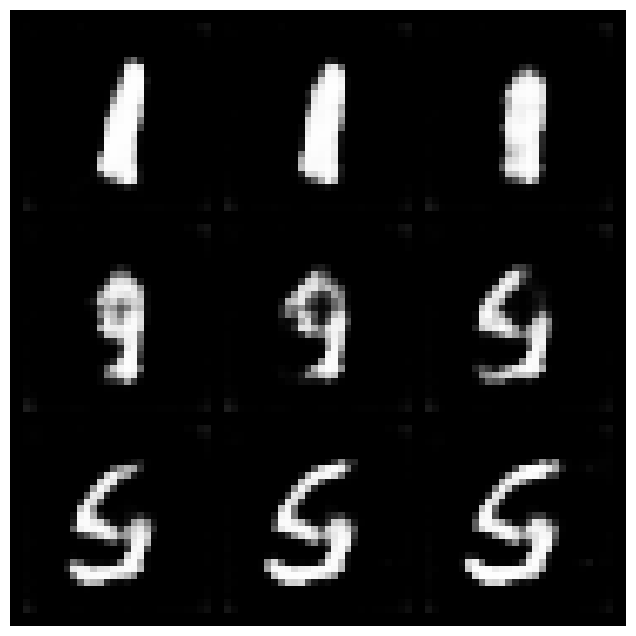

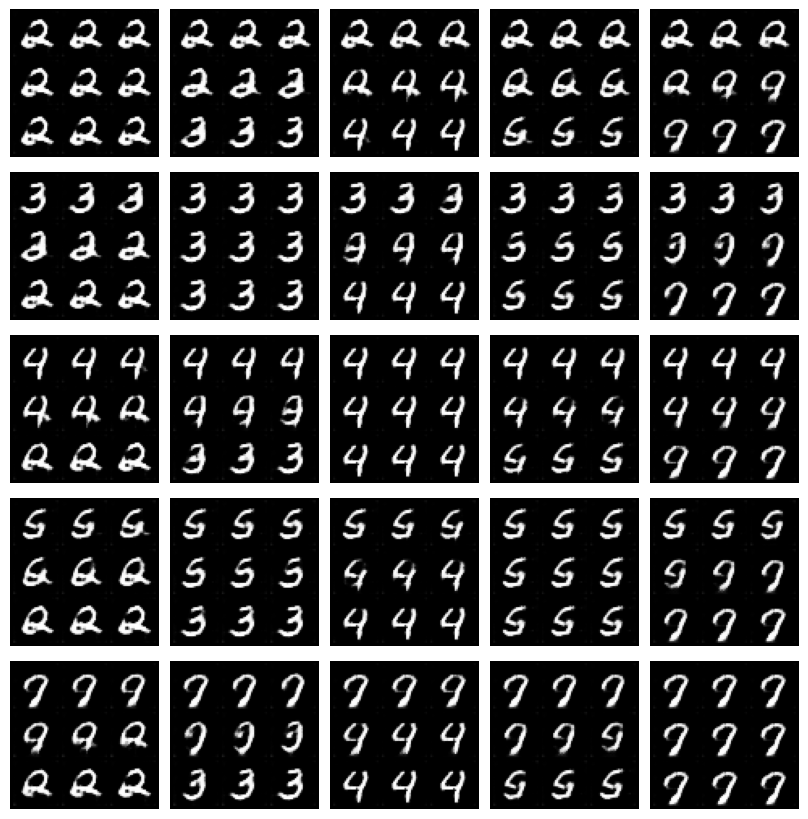

In [26]:
import math

n_interpolation = 9 # Choose the interpolation: Number of intermediate images + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculated the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combined the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)


start_plot_number = 1 # start digit
### Change me! ###
end_plot_number = 5 # end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')


#For visualizing a set of pairwise class
### Interpolations for a collection of different numbers, all in a single grid of interpolations.
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Changing the Noise Vector

Now, let's consider what occurred when the class is kept constant but altered the noise vector. Here noise vector interpolation is also implemented, generating an image at each interval.

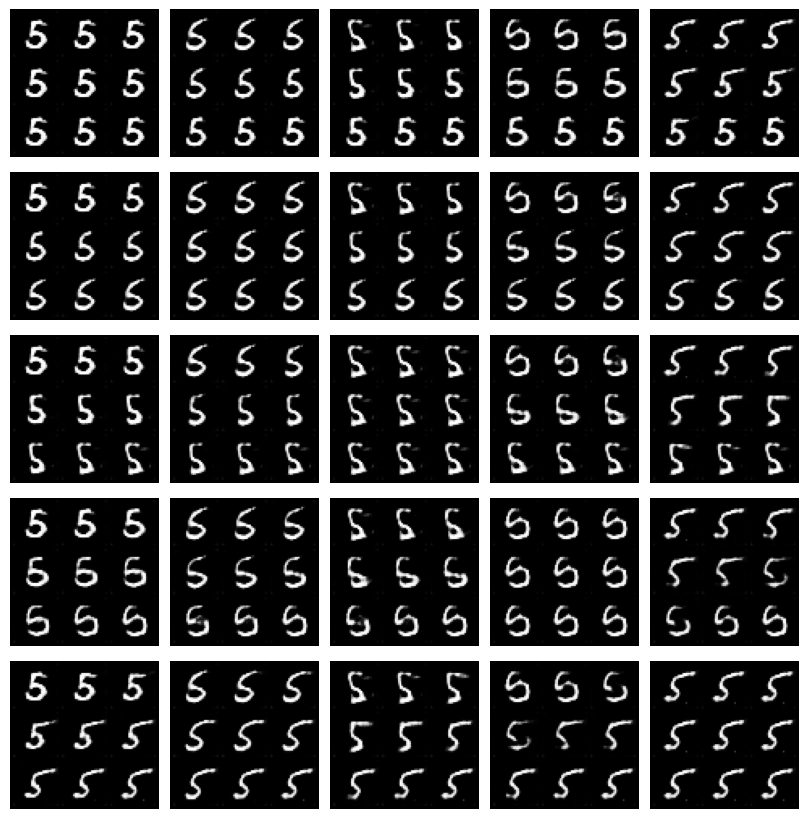

In [27]:
n_interpolation = 9 # Number of intermediate images  + 2 (for the start and end image)

# This time  interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # Interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combined the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generated noise vectors to interpolate between

n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()